# Chapter: Nonlinear System Identification


## Topic: ARX-based Modeling of Heat Exchangers 

In [2]:
# import packages
import matplotlib.pyplot as plt, numpy as np, control
from sklearn.preprocessing import StandardScaler
from sippy import system_identification as SysID
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf
from matplotlib.ticker import MaxNLocator

# package settings
plt.rcParams.update({'font.size': 14})
assert(control.__version__ < '0.9'), "To avoid errors, downgrade the control package to a version < 0.9.0. See https://github.com/CPCLAB-UNIPI/SIPPY/issues/48 for details."

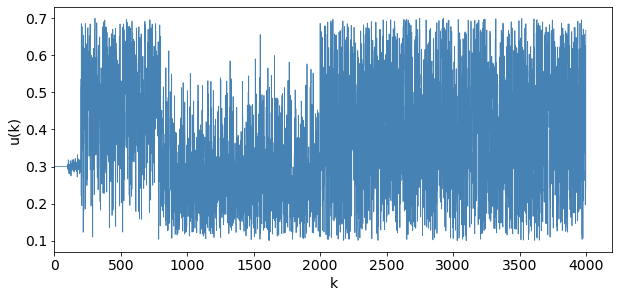

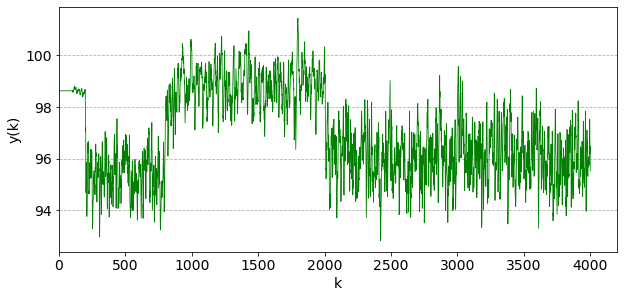

In [3]:
# read data and plot
data = np.loadtxt('exchanger.dat')
u = data[:,1, None]; y = data[:,2, None]

# plots
plt.figure(figsize=(10,4.5))
plt.plot(u, 'steelblue', linewidth=0.8, drawstyle='steps')
plt.ylabel('u(k)'), plt.xlabel('k'), plt.xlim(0)

plt.figure(figsize=(10,4.5))
plt.plot(y, 'g', linewidth=0.8)
plt.ylabel('y(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [4]:
# split into training and test dataset
u_fit = u[:3000,0:1]; u_test = u[3000:,0:1] 
y_fit = y[:3000,0:1]; y_test = y[3000:,0:1] 

In [5]:
# center data before model fitting
u_scaler = StandardScaler(with_std=False); u_fit_centered = u_scaler.fit_transform(u_fit); u_test_centered = u_scaler.transform(u_test) 
y_scaler = StandardScaler(with_std=False); y_fit_centered = y_scaler.fit_transform(y_fit); y_test_centered = y_scaler.transform(y_test)

In [6]:
# fit ARX model
ARXmodel = SysID(y_fit_centered, u_fit_centered, 'ARX', IC='AIC', na_ord=[1,20], nf_ord=[1,10], delays=[0,5])
print(ARXmodel.G)

suggested orders are: Na= 11 ; Nb= 3 Delay:  1

                                                       -0.7289 z^9 - 0.5945 z^8 - 0.7534 z^7
----------------------------------------------------------------------------------------------------------------------------------------------------
z^11 - 1.126 z^10 + 0.3999 z^9 - 0.1137 z^8 + 0.1459 z^7 - 0.1663 z^6 + 0.04029 z^5 - 0.01688 z^4 + 0.005192 z^3 + 0.0169 z^2 - 0.002195 z - 0.05719

dt = 1.0



In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         Residual analysis on training dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

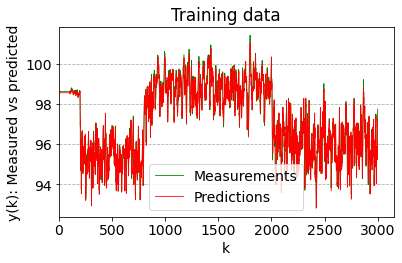

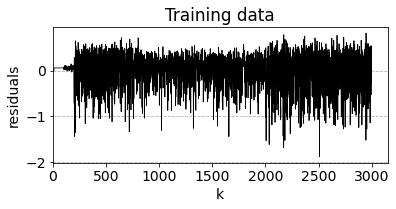

In [7]:
# get model predictions and residuals on training dataset
y_fit_predicted_centered = ARXmodel.Yid
y_fit_predicted = np.transpose(y_scaler.inverse_transform(y_fit_predicted_centered))
residuals_fit = y_fit - y_fit_predicted

plt.figure(figsize=(6,3.5)), plt.plot(y_fit, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_fit_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Training data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5)), plt.plot(residuals_fit, 'black', linewidth=0.8)
plt.title('Training data'), plt.ylabel('residuals'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

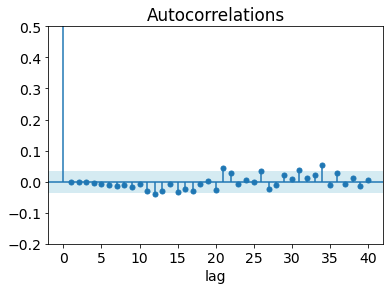

In [8]:
# ACF of residuals
conf_int = 1.96/np.sqrt(len(residuals_fit))

plot_acf(residuals_fit, lags= 40, alpha=None, title='')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xtick labels
plt.xlabel('lag'), plt.title('Autocorrelations'), plt.ylim(-0.2, 0.5) 
plt.show()
plt.show()

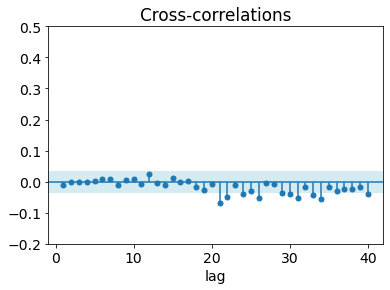

In [10]:
# CCF b/w residuals and input sequence
ccf_vals = ccf(residuals_fit, u_fit, adjusted=False) # ccf for lag > 0
ccf_vals = ccf_vals[1:41] # ccf for lag 1 to 20

# generate CCF plot
lags = np.arange(1,41)

plt.figure(figsize=(6,4)), plt.vlines(lags, [0], ccf_vals), plt.axhline(0, 0, lags[-1])
plt.plot(lags, ccf_vals, marker='o', markersize=5, linestyle='None')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.xlabel('lag'), plt.title('Cross-correlations')
plt.ylim(-0.2, 0.5) 
plt.show()

In [11]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##               m-step ahead predictions on test dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from sippy import functionset as fset

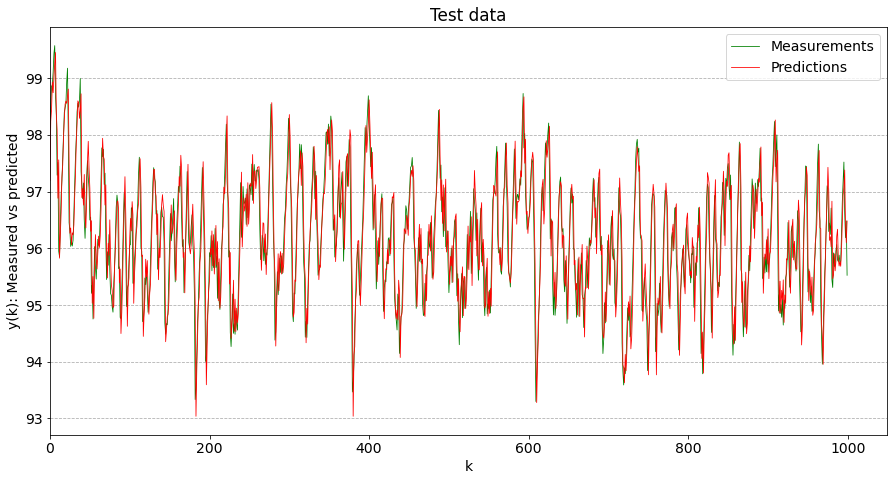

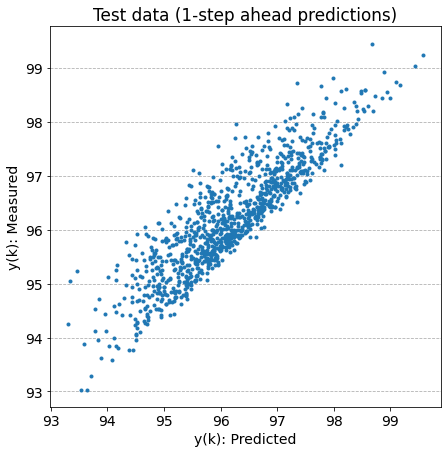

In [12]:
# #%% 1-step ahead predictions
y_test_predicted_centered = np.transpose(fset.validation(ARXmodel, u_test_centered, y_test_centered, np.linspace(0,len(u_test)-1,len(u_test)), k=1))
y_test_predicted = y_scaler.inverse_transform(y_test_predicted_centered)

plt.figure(figsize=(15,7.5)), plt.plot(y_test, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_test_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Test data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(7,7)), plt.plot(y_test, y_test_predicted, '.', linewidth=0.8)
plt.title('Test data (1-step ahead predictions)'), plt.ylabel('y(k): Measured'), plt.xlabel('y(k): Predicted')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

C:\Users\f0ne44\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1631: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


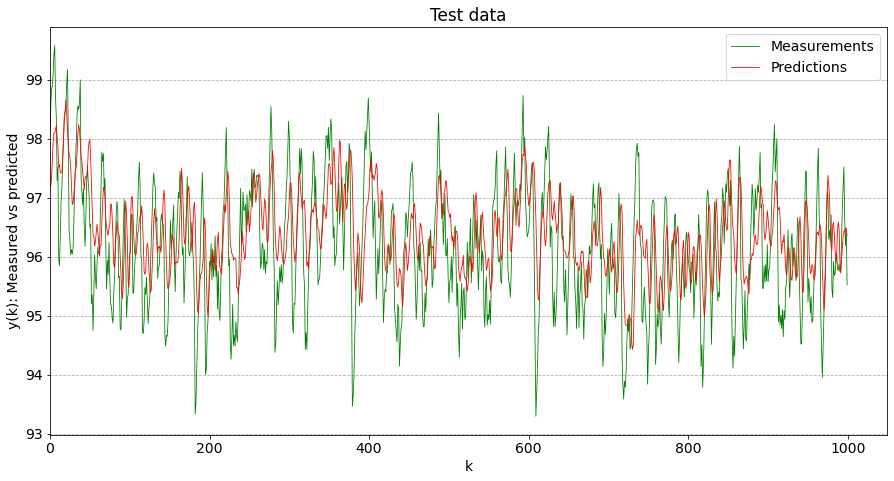

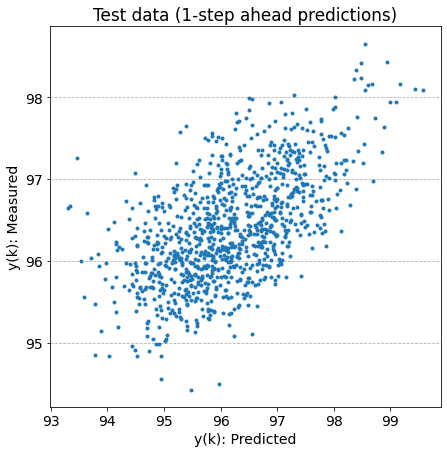

In [13]:
# 10-step ahead predictions
y_test_predicted_centered = np.transpose(fset.validation(ARXmodel, u_test_centered, y_test_centered, np.linspace(0,len(u_test)-1,len(u_test)), k=10))
y_test_predicted = y_scaler.inverse_transform(y_test_predicted_centered)

plt.figure(figsize=(15,7.5)), plt.plot(y_test, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_test_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Test data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(7,7)), plt.plot(y_test, y_test_predicted, '.', linewidth=0.8)
plt.title('Test data (1-step ahead predictions)'), plt.ylabel('y(k): Measured'), plt.xlabel('y(k): Predicted')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

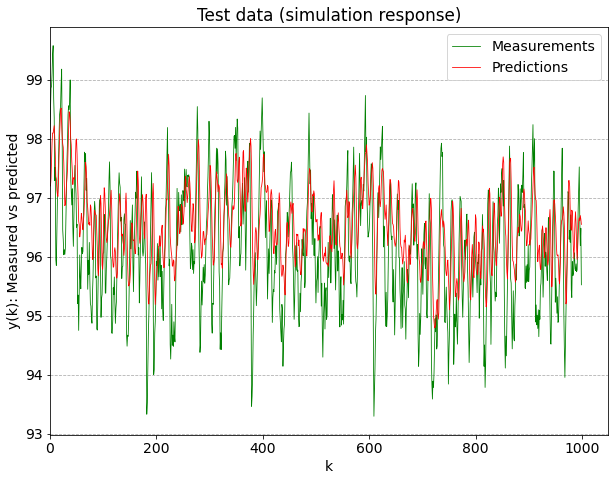

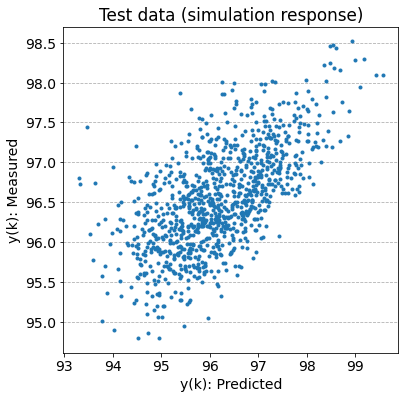

In [14]:
# infinite-step ahead predictions
y_test_predicted_centered, _, _ = control.matlab.lsim(ARXmodel.G, u_test_centered[:,0], np.linspace(0,len(u_test)-1,len(u_test)))
y_test_predicted = y_scaler.inverse_transform(y_test_predicted_centered)

plt.figure(figsize=(10,7.5)), plt.plot(y_test, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_test_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Test data (simulation response)'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,6)), plt.plot(y_test, y_test_predicted, '.', linewidth=0.8)
plt.title('Test data (simulation response)'), plt.ylabel('y(k): Measured'), plt.xlabel('y(k): Predicted')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()